In [1]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
import glob
from sncosmo.salt2utils import BicubicInterpolator
from matplotlib.ticker import ScalarFormatter, FuncFormatter
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.model_selection import train_test_split
import sncosmo
from scipy.interpolate import interp1d
from numpy import random
import pickle as pk
from astropy.table import Table
from sncosmo.constants import HC_ERG_AA
from sklearn import preprocessing

SCALE_FACTOR = 1e-12

sns.set_style("whitegrid", {'axes.grid':'False','xtick.bottom': True,'ytick.left': True})

params = {"text.usetex" : True,'font.size': 20, 'font.family':'serif', 'font.serif':'Computer Modern'}
plt.rcParams.update(params)

In [2]:
# PCA class from sklearn does not perfom complete Scaling (i.e. transform the data to zero mean and unit variance column(features) wise)
# This class perfom only centering by mean, column wise. So we extract this mean previously, after the PCA we transform this array (1 mean value per feature)
# to the new ordered basis. So the projection of the grid points on the first PC, that resembles an average SN flux surface, won't have negative values. 

In [3]:
class ScalarFormatterClass1(ScalarFormatter):
    def _set_format(self):
        self.format = "%1.1f"

In [4]:
p_grid=np.arange(-10,51,1)
w_grid1=np.arange(3350,8710,10)
w_grid2=np.arange(3400,8410,10)

In [5]:
fname=[]
for file in glob.glob("./final_SEDs/*.dat"):
    fname.append(file.split("/")[2].split(".")[0])

In [6]:
exclude=["Train_SN93_SED","Test_SN15_SED","Test_SN26_SED","Train_SN30_SED","Train_SN96_SED"]

In [7]:
data=[]
sne_names=[]
for sn in fname:
    if sn not in exclude:
        data.append(pd.read_csv(f"./final_SEDs/{sn}.dat")["flux"].values)
        sne_names.append(sn)

In [8]:
len(data)

164

## Applying PCA

In [9]:
train_data, test_data, train_names, test_names=train_test_split(data,sne_names,test_size=0.1,random_state=0)

In [10]:
Means=np.mean(train_data,axis=1)

In [11]:
len(Means)

147

In [12]:
len(train_data)

147

In [13]:
np.mean(train_data[0])

0.06598197666597747

In [14]:
np.std(train_data[0])

0.0707685317487314

In [15]:
mean_cor_data=[train_data[i]-Means[i] for i in range(len(train_data))]

In [16]:
training_data=np.array(mean_cor_data).T

In [17]:
training_data.shape

(30561, 147)

In [18]:
pca = PCA(10)
pca.fit(training_data)
newvariables=pca.transform(training_data)

In [19]:
newvariables.shape

(30561, 10)

In [52]:
np.mean(newvariables[::,0])

1.4879989230930407e-17

In [53]:
np.std(newvariables[::,0])

0.8588691340374706

In [54]:
newvariables[::,0]

array([ 0.94008217,  1.1765956 ,  1.50596156, ..., -0.74886469,
       -0.75201245, -0.7554721 ])

In [55]:
np.dot(training_data,pca.components_[0]) # projetando os dados na primeira componente principal

array([ 0.94008217,  1.1765956 ,  1.50596156, ..., -0.74886469,
       -0.75201245, -0.7554721 ])

In [56]:
np.sum(pca.explained_variance_ratio_[:3])*100

98.21593694362625

In [57]:
np.sum(pca.explained_variance_ratio_[:10])*100

99.25689338511802

In [58]:
pca.explained_variance_ratio_[:10]

array([9.63007665e-01, 1.26885215e-02, 6.46318317e-03, 3.75066862e-03,
       1.87427791e-03, 1.35020458e-03, 1.08028617e-03, 9.00751722e-04,
       7.65903734e-04, 6.87471676e-04])

In [59]:
Means_transformed=pca.transform(Means.reshape(1, -1))

In [60]:
pca.components_.shape

(10, 147)

In [27]:
Means.reshape(1, -1)

array([[0.06598198, 0.07636915, 0.07131505, 0.04515383, 0.08801059,
        0.05892789, 0.05867979, 0.04139114, 0.0464325 , 0.05467567,
        0.05759686, 0.07069625, 0.04927618, 0.05584468, 0.07336066,
        0.11721421, 0.03133133, 0.05543782, 0.03608717, 0.05275541,
        0.05731496, 0.04325832, 0.01567472, 0.07472185, 0.07017104,
        0.04427059, 0.06060524, 0.10402757, 0.04821589, 0.06854006,
        0.04700676, 0.01501117, 0.09669967, 0.04562504, 0.05280698,
        0.04384909, 0.07162469, 0.05983604, 0.05326231, 0.0448599 ,
        0.10085401, 0.07062957, 0.06521558, 0.05956035, 0.02409036,
        0.09941132, 0.05997178, 0.07893686, 0.06580641, 0.05399306,
        0.00539823, 0.04995551, 0.03975734, 0.07835266, 0.03324708,
        0.09244754, 0.04271457, 0.06399298, 0.08230851, 0.07521016,
        0.08934015, 0.07230314, 0.05615916, 0.08942605, 0.05196059,
        0.04940476, 0.07151643, 0.08916993, 0.03893819, 0.08537601,
        0.06633911, 0.04267671, 0.04392233, 0.06

In [33]:
np.dot(Means,pca.components_[0]) # Aqui isso funciona sem problemas, no FA não.

0.8030716663069122

In [28]:
Means_transformed

array([[ 0.80307167,  0.00262042,  0.01472169, -0.04437414, -0.02128258,
        -0.00799555, -0.00559656, -0.01108193, -0.0218079 , -0.00159329]])

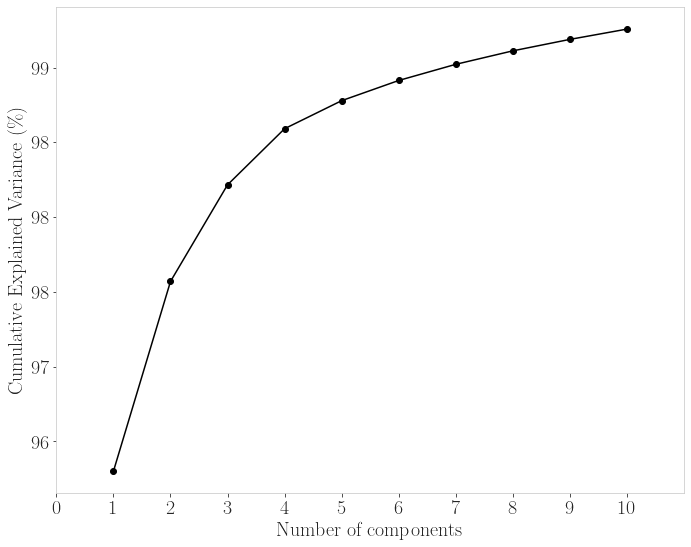

In [29]:
fig,ax = plt.subplots(1,1,figsize=(10,8))
ax.plot(np.linspace(1,10,10),np.cumsum(pca.explained_variance_ratio_),"-o",c="black")
ax.set_xlim(0,11)
ax.set_xticks(np.arange(11))
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 
ax.set_xlabel("Number of components")
ax.set_ylabel("Cumulative Explained Variance (\%)");

fig.tight_layout()
plt.savefig('./pca/cumulative_exp_variance.pdf')  

In [30]:
np.cumsum(pca.explained_variance_ratio_)

array([0.96300766, 0.97569619, 0.98215937, 0.98591004, 0.98778432,
       0.98913452, 0.99021481, 0.99111556, 0.99188146, 0.99256893])

In [31]:
X, Y=np.meshgrid(p_grid,w_grid2)

In [32]:
len(pca.components_[0])

147

In [33]:
M0=newvariables[::,0].reshape(X.shape)+Means_transformed[0][0]
M1=newvariables[::,1].reshape(X.shape)+Means_transformed[0][1]
M2=newvariables[::,2].reshape(X.shape)+Means_transformed[0][2]
M3=newvariables[::,3].reshape(X.shape)+Means_transformed[0][3]
M4=newvariables[::,4].reshape(X.shape)+Means_transformed[0][4]
M5=newvariables[::,5].reshape(X.shape)+Means_transformed[0][5]
M6=newvariables[::,6].reshape(X.shape)+Means_transformed[0][6]
M7=newvariables[::,7].reshape(X.shape)+Means_transformed[0][7]
M8=newvariables[::,8].reshape(X.shape)+Means_transformed[0][8]
M9=newvariables[::,9].reshape(X.shape)+Means_transformed[0][9]

In [34]:
np.savetxt("./pca/M0_pca.txt",M0)
np.savetxt("./pca/M1_pca.txt",M1)
np.savetxt("./pca/M2_pca.txt",M2)
np.savetxt("./pca/M3_pca.txt",M3)
np.savetxt("./pca/M4_pca.txt",M4)
np.savetxt("./pca/M5_pca.txt",M5)
np.savetxt("./pca/M6_pca.txt",M6)
np.savetxt("./pca/M7_pca.txt",M7)
np.savetxt("./pca/M8_pca.txt",M8)
np.savetxt("./pca/M9_pca.txt",M9)

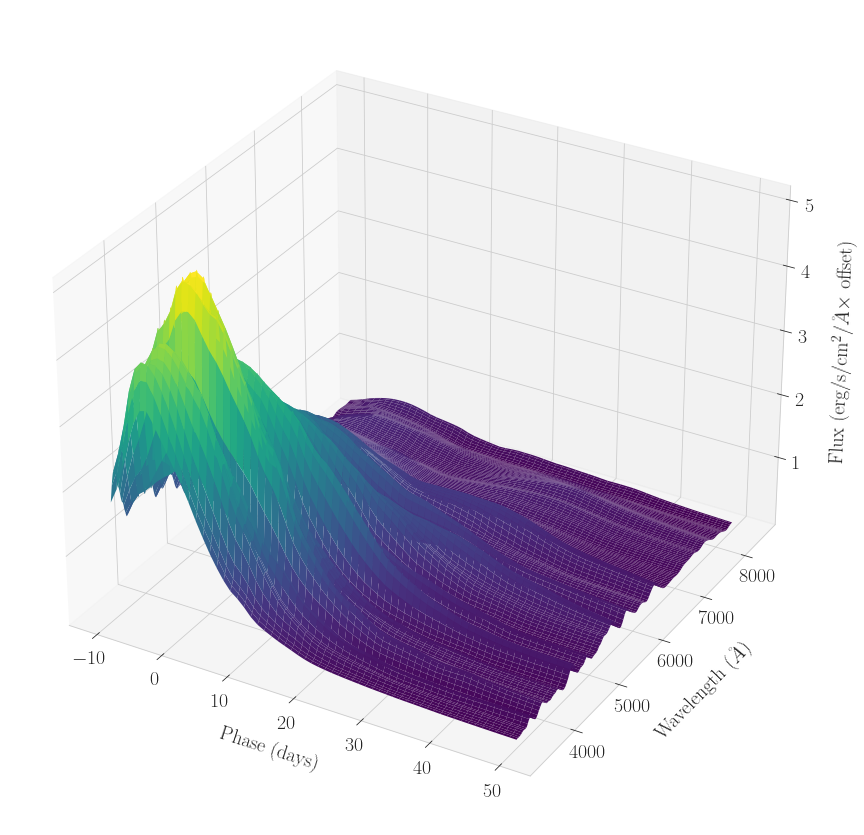

In [35]:
pp = PdfPages(f"./pca/M0.pdf")

fig = plt.figure(figsize=(15,12))
ax = plt.axes(projection='3d')

g=ax.plot_surface(X,Y,M0,cmap="viridis",edgecolor='none',ccount=200,rcount=200)
ax.set_xlabel(r"Phase (days)")
ax.set_ylabel(r"Wavelength ($\AA$)")
ax.set_zlabel(r"Flux (erg/s/cm$^2$/$\AA \times$ offset)")
ax.yaxis.labelpad=20
ax.xaxis.labelpad=15
ax.zaxis.labelpad=15
fig.tight_layout()
#fig.colorbar(g, ax=ax)
#plt.show()
pp.savefig()
pp.close()

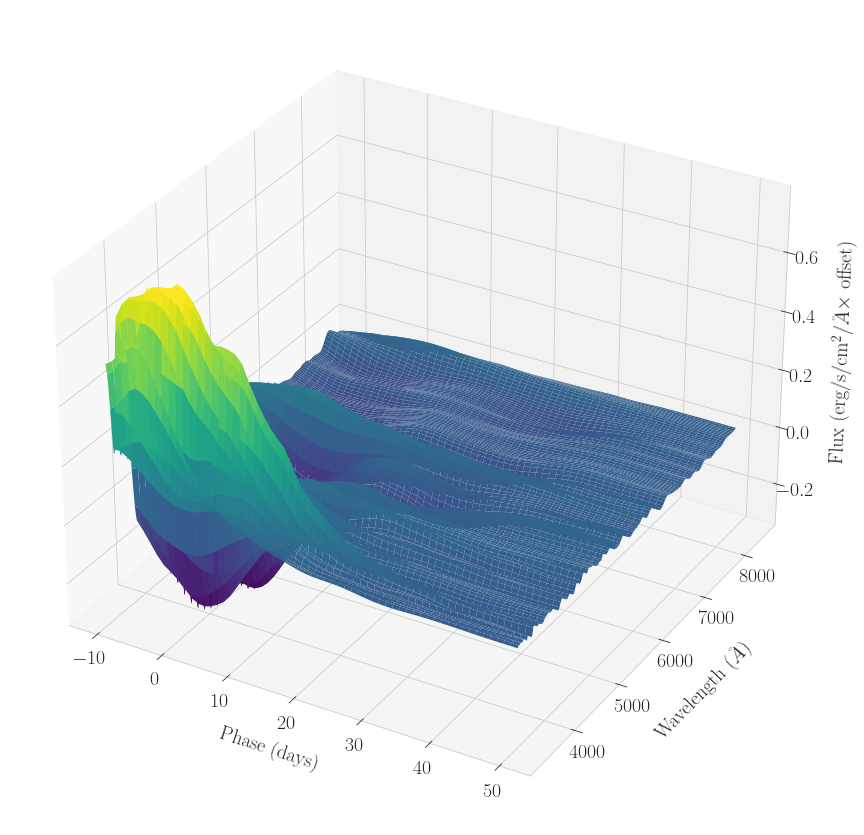

In [36]:
pp = PdfPages(f"./pca/M1.pdf")

fig = plt.figure(figsize=(15,12))
ax = plt.axes(projection='3d')

g=ax.plot_surface(X,Y,M1,cmap="viridis",edgecolor='none',ccount=200,rcount=200)
ax.set_xlabel(r"Phase (days)")
ax.set_ylabel(r"Wavelength ($\AA$)")
ax.set_zlabel(r"Flux (erg/s/cm$^2$/$\AA \times$ offset)")
ax.yaxis.labelpad=20
ax.xaxis.labelpad=15
ax.zaxis.labelpad=15
fig.tight_layout()
#fig.colorbar(g, ax=ax)
#plt.show()
pp.savefig()
pp.close()

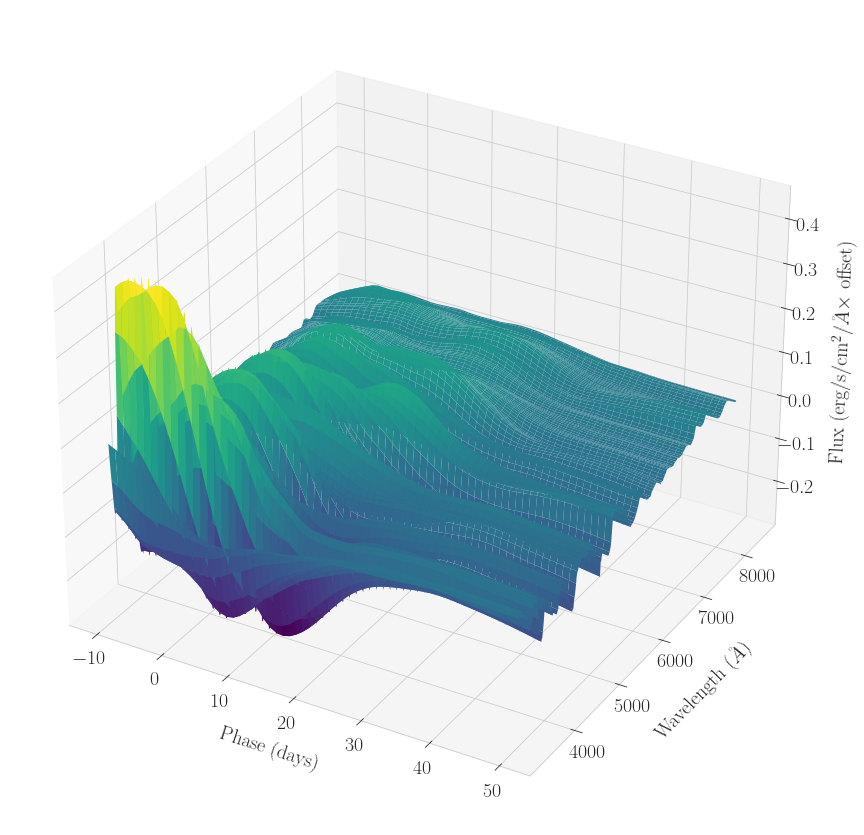

In [37]:
pp = PdfPages(f"./pca/M2.pdf")

fig = plt.figure(figsize=(15,12))
ax = plt.axes(projection='3d')

g=ax.plot_surface(X,Y,M2,cmap="viridis",edgecolor='none',ccount=200,rcount=200)
ax.set_xlabel(r"Phase (days)")
ax.set_ylabel(r"Wavelength ($\AA$)")
ax.set_zlabel(r"Flux (erg/s/cm$^2$/$\AA \times$ offset)")
ax.yaxis.labelpad=20
ax.xaxis.labelpad=15
ax.zaxis.labelpad=15
fig.tight_layout()
#fig.colorbar(g, ax=ax)
#plt.show()
pp.savefig()
pp.close()

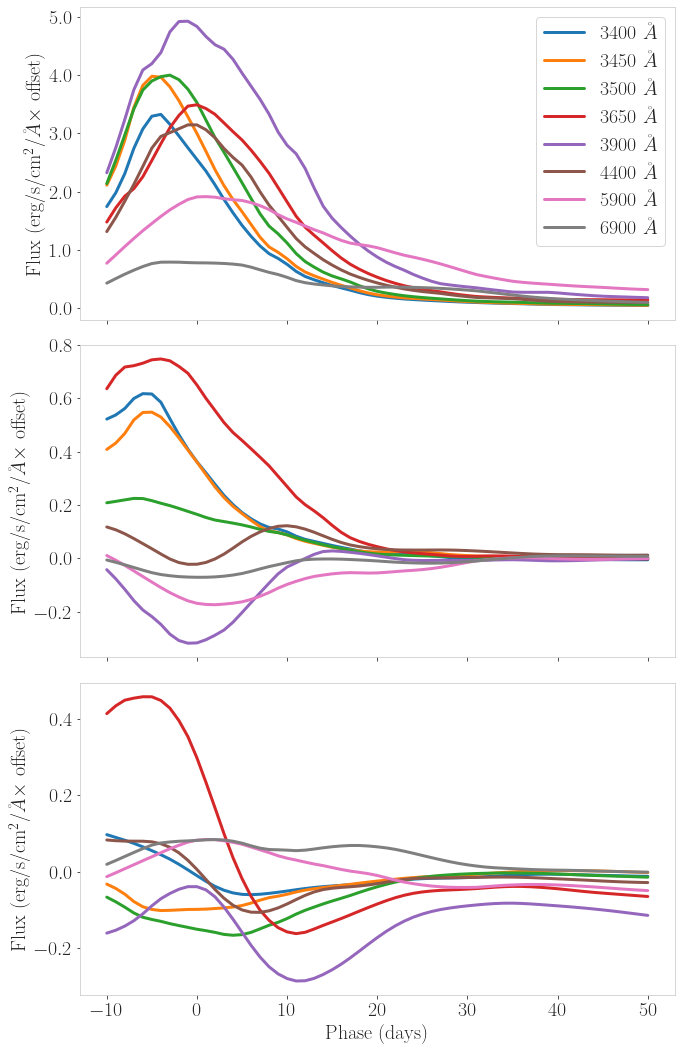

In [38]:
fig, axs = plt.subplots(3,1,figsize=(10,15),sharex=True)

colors=["#1f77b4","#ff7f0e","#2ca02c","#d62728","#9467bd","#8c564b","#e377c2","#7f7f7f"]#"#fde725","#a0da39","#4ac16d","#1fa187","#277f8e","#365c8d","#46327e","#440154"]
for j,i in enumerate([0,5,10,25,50,100,250,350]):#
    axs[0].plot(X[i],M0[i],label=f"{int(Y[i][0])} $\AA$",lw=3,color=colors[j])
    #ax1.set_xlabel("Phase (days)")
    axs[0].set_ylabel(r"Flux (erg/s/cm$^2$/$\AA \times$ offset)")
    #ax1.set_title("First Principal Component")
    formatter11=ScalarFormatterClass1()
    formatter11.set_scientific(True)
    formatter11.set_powerlimits((0,0))
    axs[0].yaxis.set_major_formatter(formatter11)
    axs[0].legend()
for j,i in enumerate([0,5,10,25,50,100,250,350]):
    axs[1].plot(X[i],M1[i],label=f"{int(Y[i][0])} $\AA$",lw=3,color=colors[j])
    #ax2.set_xlabel("Phase (days)")
    axs[1].set_ylabel(r"Flux (erg/s/cm$^2$/$\AA \times$ offset)")
    #ax2.set_title("Second Principal Component")
    formatter11=ScalarFormatterClass1()
    formatter11.set_scientific(True)
    formatter11.set_powerlimits((0,0))
    #axs[1].yaxis.set_major_formatter(formatter11)
    #axs[1].legend(loc=1)
for j,i in enumerate([0,5,10,25,50,100,250,350]):
    axs[2].plot(X[i],M2[i],label=f"{int(Y[i][0])} $\AA$",lw=3,color=colors[j])
    axs[2].set_xlabel("Phase (days)")
    axs[2].set_ylabel(r"Flux (erg/s/cm$^2$/$\AA \times$ offset)")
    #ax3.set_title("Third Principal Component")
    formatter11=ScalarFormatterClass1()
    formatter11.set_scientific(True)
    formatter11.set_powerlimits((0,0))
    #axs[2].yaxis.set_major_formatter(formatter11)
    #axs[2].legend(loc=1)
    
fig.tight_layout()
plt.savefig('./pca/PCA_components.pdf')  
#plt.show()

# First, Second and Third Principal Components

## Creating synthetic photometry from test data

In [39]:
filters=["cspg","cspr","cspv9844"]

In [40]:
filters_label=["CSP-G","CSP-R","CSP-V9844"]

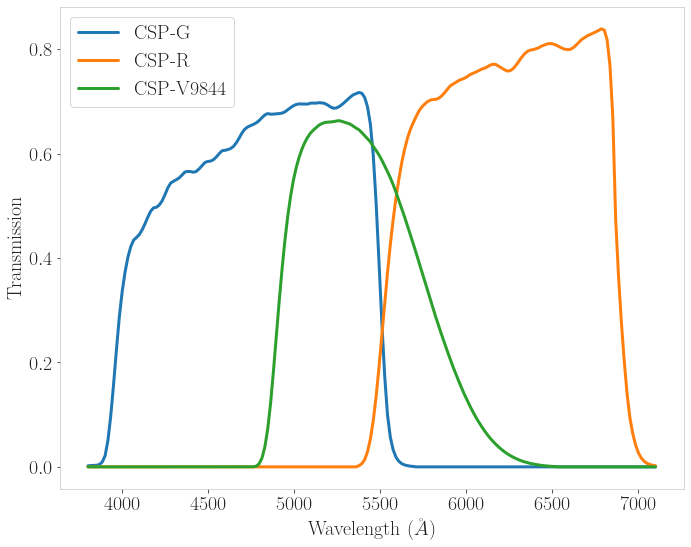

In [41]:
fig=plt.figure(figsize=(10,8))
colors=["#1f77b4","#ff7f0e","#2ca02c"]#"#fde725","#21918c","#440154"]
for j,f in enumerate(filters):
    plt.plot(np.linspace(3800,7100,200),sncosmo.get_bandpass(f)(np.linspace(3800,7100,200)),label=filters_label[j],lw=3,color=colors[j])
plt.xlabel("Wavelength ($\AA$)")
plt.ylabel("Transmission")
plt.legend(loc=2)
#plt.show()
fig.tight_layout()
plt.savefig('./pca/validation_fits_filters.pdf')  

# Default unit transmission in sncosmo: ratio of transmitted to incident photons.

In [42]:
d={}
for i in range(len(test_data)):
    d[i]=test_data[i].reshape(Y.shape)*SCALE_FACTOR

## Validating the PCA

In [43]:
class EXP_LC(sncosmo.Source):
    
    _param_names = ['x0', 'x1', 'x2','x3','x4','x5','x6','x7','x8','x9']
    param_names_latex = ['x_0', 'x_1', 'x_2', 'x_3', 'x_4', 'x_5', 'x_6', 'x_7', 'x_8', 'x_9']
    
    
    def __init__(self, phase, wave, flux0, flux1, flux2, flux3, flux4, flux5, flux6, flux7, flux8, flux9, name='EXP', version='2022'):

        self.name = name
        self.version = version
        self._phase = phase
        self._wave = wave
        
        self._model_flux0  = BicubicInterpolator(phase, wave, flux0.T)
        self._model_flux1  = BicubicInterpolator(phase, wave, flux1.T)
        self._model_flux2  = BicubicInterpolator(phase, wave, flux2.T)
        self._model_flux3  = BicubicInterpolator(phase, wave, flux3.T)
        self._model_flux4  = BicubicInterpolator(phase, wave, flux4.T)
        self._model_flux5  = BicubicInterpolator(phase, wave, flux5.T)
        self._model_flux6  = BicubicInterpolator(phase, wave, flux6.T)
        self._model_flux7  = BicubicInterpolator(phase, wave, flux7.T)
        self._model_flux8  = BicubicInterpolator(phase, wave, flux8.T)
        self._model_flux9  = BicubicInterpolator(phase, wave, flux9.T)

        self._parameters = np.array([1,0,0,0,0,0,0,0,0,0])  # initial guess
        

    def _flux(self, phase, wave):
        
        x0, x1, x2, x3, x4, x5, x6, x7, x8, x9= self._parameters
        #print('flux!')
        return x0 * (self._model_flux0(phase, wave) +  x1 * self._model_flux1(phase, wave) +  x2 * self._model_flux2(phase, wave)+  x3 * self._model_flux3(phase, wave)+  x4 * self._model_flux4(phase, wave)+  x5 * self._model_flux5(phase, wave)+  x6 * self._model_flux6(phase, wave)+  x7 * self._model_flux7(phase, wave)+  x8 * self._model_flux8(phase, wave)+  x9 * self._model_flux9(phase, wave))
    
    # Para adicionar bandflux relative variance precisaríamos de superfícies com incerteza do modelo. E construir uma matriz ainda maior para incluir a covariância, onde levaríamos tbm em conta os erros de correção K

In [44]:
exp_pca = EXP_LC(p_grid, w_grid2, M0*SCALE_FACTOR, M1*SCALE_FACTOR, M2*SCALE_FACTOR, M3*SCALE_FACTOR, M4*SCALE_FACTOR, M5*SCALE_FACTOR, M6*SCALE_FACTOR, M7*SCALE_FACTOR, M8*SCALE_FACTOR, M9*SCALE_FACTOR)

In [45]:
csp=sncosmo.get_magsystem("csp")

In [46]:
file=open("./pca/validation_fit_results.dat","w")

In [47]:
for k in range(len(d)):
    print(test_names[k])
    fig,axs=plt.subplots(3,1,figsize=(8,12),sharex=True)
    colors=["#1f77b4","#ff7f0e","#2ca02c"]#"#fde725","#21918c","#440154"]
    filt=[]
    ph=[]
    fl=[]
    flerr=[]
    for j,f in enumerate(filters):
        lc=interp1d(p_grid,np.sum(d[k]*sncosmo.get_bandpass(f)(Y)*Y*10/HC_ERG_AA,axis=0))     # int dlambda F_lambda  T^X lambda/hc
        #specs=[sncosmo.Spectrum(Y.T[t],d[k].T[t]) for t in range(len(p_grid))]     # Fotometria sintética via sncosmo, resultados exatamente iguais
        #ph=[specs[k].bandflux(f) for k in range(len(p_grid))]
        #axs[j].plot(p_grid,ph)

        np.random.seed(42)
        p_random=np.random.choice(np.linspace(-10,50,61), size=15, replace=False)
        np.random.seed(42)
        y_err=lc(p_random)*np.array([random.rand() for i in range(15)])/10
        
        filt.append([f]*len(p_random))
        ph.append(list(p_random))
        fl.append(list(lc(p_random)))
        flerr.append(list(y_err))
        #axs[j].errorbar(p_random,lc(p_random),yerr=y_err,label=f"Flux through {f} filter",color=colors[j],ls="none",fmt='o')
    
    df={"time":np.array(ph).reshape(-1),"flux":np.array(fl).reshape(-1),"fluxerr":np.array(flerr).reshape(-1),"flt":np.array(filt).reshape(-1)}
    df=pd.DataFrame(df)
    df["zpsys"]="csp"
    
    zp=[]
    for j in df["flt"]:
        zp.append(2.5*np.log10(csp.zpbandflux(j)))

    df["zp"]=zp

    dust = sncosmo.F99Dust()
    model = sncosmo.Model(source=exp_pca) # retirei a correção por poeira pois os dados originais já estavam corrigidos para poeira na MW
    model.set(z=0.,t0=0.) 
    dat=Table.from_pandas(df)
    dat.remove_rows(np.where(dat["flux"]<0.))
    dat.remove_rows(np.where(dat["fluxerr"]<0.))

    result, fitted_model = sncosmo.fit_lc(dat, model, ['x0', 'x1', 'x2'],modelcov=False, phase_range=(-10, 50.), wave_range=(3500.,8400.), verbose=False)
    result2, fitted_model2= sncosmo.fit_lc(dat, model, ['x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9'],modelcov=False, phase_range=(-10, 50.), wave_range=(3500.,8400.), verbose=False)

    file.write(f"{test_names[k]}:\n")
    file.write(f"EXP3(PCA) fit chi2/ndof={round(result.chisq/result.ndof,2)}\n")
    file.write(f"x0={round(result.parameters[2],4)} +/- {round(result.errors['x0'],4)}, x1={round(result.parameters[3],4)} +/- {round(result.errors['x1'],4)}, x2={round(result.parameters[4],4)} +/- {round(result.errors['x2'],4)}\n")
    file.write(f"EXP10(PCA) fit chi2/ndof={round(result2.chisq/result2.ndof,2)}\n")
    file.write(f"x0={round(result2.parameters[2],4)} +/- {round(result2.errors['x0'],4)}, x1={round(result2.parameters[3],4)} +/- {round(result2.errors['x1'],4)}, x2={round(result2.parameters[4],4)} +/- {round(result2.errors['x2'],4)}\n")
    file.write(f"x3={round(result2.parameters[5],4)} +/- {round(result2.errors['x3'],4)}, x4={round(result2.parameters[6],4)} +/- {round(result2.errors['x4'],4)}, x5={round(result2.parameters[7],4)} +/- {round(result2.errors['x5'],4)}\n")
    file.write(f"x6={round(result2.parameters[7],4)} +/- {round(result2.errors['x6'],4)}, x7={round(result2.parameters[9],4)} +/- {round(result2.errors['x7'],4)}, x8={round(result2.parameters[10],4)} +/- {round(result2.errors['x8'],4)}\n")
    file.write(f"x9={round(result2.parameters[11],4)} +/- {round(result2.errors['x9'],4)}\n\n")
    
    for j,f in enumerate(filters):
        axs[j].errorbar(dat[dat["flt"]==f]["time"], dat[dat["flt"]==f]["flux"]*10**(-0.4*dat[dat["flt"]==f]["zp"]+11), yerr=dat[dat["flt"]==f]["fluxerr"]*10**(-0.4*dat[dat["flt"]==f]["zp"]+11),label=f"Synthetic photometry in {filters_label[j]}",color=colors[j],ls="none",fmt='o')
        axs[j].plot(np.linspace(-10,50,100),fitted_model.bandflux(f, np.linspace(-10,50,100))*10**(-0.4*dat[dat["flt"]==f]["zp"][0]+11),linewidth=3,color=colors[j])#,label=f"EXP3(PCA) fit ($\chi^2/ndof$={round(result.chisq/result.ndof,2)})")
        axs[j].plot(np.linspace(-10,50,100),fitted_model2.bandflux(f, np.linspace(-10,50,100))*10**(-0.4*dat[dat["flt"]==f]["zp"][0]+11),":",linewidth=3,color=colors[j])#,label=f"EXP10(PCA) fit ($\chi^2/ndof$={round(result2.chisq/result2.ndof,2)})")
        axs[j].set_ylabel(r"Flux $ZP_{AB}=27.5$")
        formatter11=ScalarFormatterClass1()
        formatter11.set_scientific(True)
        formatter11.set_powerlimits((0,0))
        axs[j].yaxis.set_major_formatter(formatter11)
        axs[j].legend(loc=3)
        if j==len(filters)-1:
            axs[j].set_xlabel("Phase (days)")
            
    #plt.show()
    fig.tight_layout()
    plt.savefig(f"./pca/validation_fit_PCA_{test_names[k]}.pdf")  
    plt.close(fig)
    #sncosmo.plot_lc(dat,model=fitted_model,errors=result.errors,zp=27.5)
file.close()

Train_SN45_SED


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Test_SN9_SED


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN100_SED


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN121_SED


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Test_SN27_SED


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN58_SED


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN95_SED


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN38_SED


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Test_SN42_SED


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN56_SED


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN23_SED


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN17_SED


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN63_SED


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN109_SED


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Test_SN30_SED


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Train_SN12_SED


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Test_SN18_SED


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
